In [1]:
import os
import shutil
import argparse
from collections import namedtuple

import numpy as np
import numpy.random as npr

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

# Introduction to SATNet

In [2]:
import satnet
print('SATNet document\n', satnet.SATNet.__doc__)

SATNet document
 Apply a SATNet layer to complete the input probabilities.

    Args:
        n: Number of input variables.
        m: Rank of the clause matrix.
        aux: Number of auxiliary variables.

        max_iter: Maximum number of iterations for solving
            the inner optimization problem.
            Default: 40
        eps: The stopping threshold for the inner optimizaiton problem.
            The inner Mixing method will stop when the function decrease
            is less then eps times the initial function decrease.
            Default: 1e-4
        prox_lam: The diagonal increment in the backward linear system
            to make the backward pass more stable.
            Default: 1e-2
        weight_normalize: Set true to perform normlization for init weights.
            Default: True

    Inputs: (z, is_input)
        **z** of shape `(batch, n)`: 
            Float tensor containing the probabilities (must be in [0,1]).
        **is_input** of shape `(batch, 

In [3]:
class SudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(SudokuSolver, self).__init__()
        n = boardSz**6
        self.sat = satnet.SATNet(n, m, aux)

    def forward(self, y_in, mask):
        out = self.sat(y_in, mask)
        del y_in, mask
        return out

In [4]:
class DigitConv(nn.Module):
    '''
    Convolutional neural network for MNIST digit recognition. From:
    https://github.com/pytorch/examples/blob/master/mnist/main.py
    '''
    def __init__(self):
        super(DigitConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)[:,:9].contiguous()

class MNISTSudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(MNISTSudokuSolver, self).__init__()
        self.digit_convnet = DigitConv()
        self.sudoku_solver = SudokuSolver(boardSz, aux, m)
        self.boardSz = boardSz
        self.nSq = boardSz**2
    
    def forward(self, x, is_inputs):
        nBatch = x.shape[0]
        x = x.flatten(start_dim = 0, end_dim = 1)
        digit_guess = self.digit_convnet(x)
        puzzles = digit_guess.view(nBatch, self.nSq * self.nSq * self.nSq)

        solution = self.sudoku_solver(puzzles, is_inputs)
        return solution

In [5]:
from exps.sudoku import train, test, FigLogger, find_unperm
args_dict = {'lr': 2e-3, 
             'cuda': torch.cuda.is_available(), 
             'batchSz': 40,
             'mnistBatchSz': 50,
             'boardSz': 3, # for 9x9 Sudoku
             'm': 600,
             'aux': 300,
             'nEpoch': 100
            }
args = namedtuple('Args', args_dict.keys())(*args_dict.values())

# The Sudoku Datasets

In [6]:
def process_inputs(X, Ximg, Y, boardSz):
    is_input = X.sum(dim=3, keepdim=True).expand_as(X).int().sign()

    Ximg = Ximg.flatten(start_dim=1, end_dim=2)
    Ximg = Ximg.unsqueeze(2).float()

    X      = X.view(X.size(0), -1)
    Y      = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)

    return X, Ximg, Y, is_input

with open('sudoku/features.pt', 'rb') as f:
    X_in = torch.load(f)
with open('sudoku/features_img.pt', 'rb') as f:
    Ximg_in = torch.load(f)
with open('sudoku/labels.pt', 'rb') as f:
    Y_in = torch.load(f)
with open('sudoku/perm.pt', 'rb') as f:
    perm = torch.load(f)

X, Ximg, Y, is_input = process_inputs(X_in, Ximg_in, Y_in, args.boardSz)
if args.cuda: X, Ximg, is_input, Y = X.cuda(), Ximg.cuda(), is_input.cuda(), Y.cuda()

N = X_in.size(0)
nTrain = int(N*0.9)

sudoku_train = TensorDataset(X[:nTrain], is_input[:nTrain], Y[:nTrain])
sudoku_test =  TensorDataset(X[nTrain:], is_input[nTrain:], Y[nTrain:])
perm_train = TensorDataset(X[:nTrain,perm], is_input[:nTrain,perm], Y[:nTrain,perm])
perm_test =  TensorDataset(X[nTrain:,perm], is_input[nTrain:,perm], Y[nTrain:,perm])
mnist_train = TensorDataset(Ximg[:nTrain], is_input[:nTrain], Y[:nTrain])
mnist_test =  TensorDataset(Ximg[nTrain:], is_input[nTrain:], Y[nTrain:])

## Sudoku

tensor([[6, 7, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 3, 0, 4, 0, 0, 8, 2],
        [0, 4, 0, 0, 0, 5, 1, 3, 6],
        [0, 0, 0, 7, 3, 0, 0, 9, 0],
        [3, 0, 4, 2, 0, 6, 0, 7, 0],
        [0, 0, 1, 0, 9, 0, 6, 0, 0],
        [5, 0, 9, 0, 0, 8, 0, 0, 0],
        [0, 0, 0, 9, 5, 0, 2, 0, 8],
        [0, 0, 0, 1, 2, 7, 4, 0, 0]])



## One-hot encoded Boolean Sudoku

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

## MNIST Sudoku

<IPython.core.display.Javascript object>


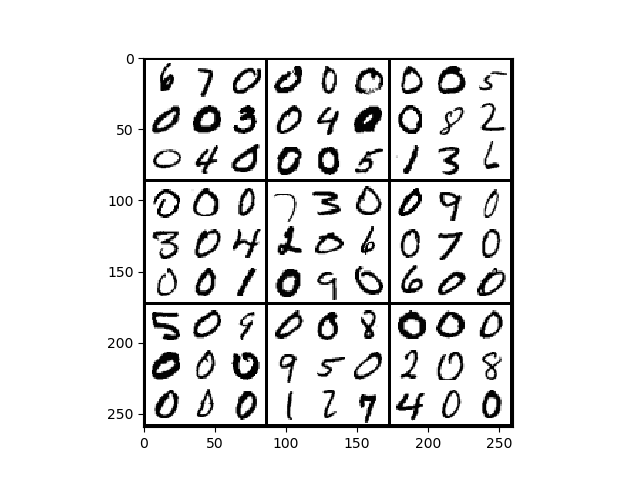

In [7]:
def show_sudoku(raw):
    return (torch.argmax(raw,2)+1)*(raw.sum(2).long())

def show_mnist_sudoku(raw):
    A = raw.numpy()
    digits = np.concatenate(np.concatenate(A,axis=1), axis=1).astype(np.uint8)
    linewidth = 2
    board = np.zeros((digits.shape[0]+linewidth*4, digits.shape[1]+linewidth*4), dtype=np.uint8)
    gridwidth = digits.shape[0]//3

    board[:] = 255
    for i in range(3):
        for j in range(3):
            xoff = linewidth+(linewidth+gridwidth)*i
            yoff = linewidth+(linewidth+gridwidth)*j
            xst = gridwidth*i
            yst = gridwidth*j
            board[xoff:xoff+gridwidth, yoff:yoff+gridwidth] = digits[xst:xst+gridwidth, yst:yst+gridwidth]

    #img = Image.fromarray(255-board)
    plt.imshow(255-board, cmap='gray')

display(Markdown('## Sudoku'))
print(show_sudoku(X_in[0]))
print()
display(Markdown('## One-hot encoded Boolean Sudoku'))
print(X[0])
    
display(Markdown('## MNIST Sudoku'))
show_mnist_sudoku(Ximg_in[0])

# The Boolean Sudoku Experiment

<IPython.core.display.Javascript object>


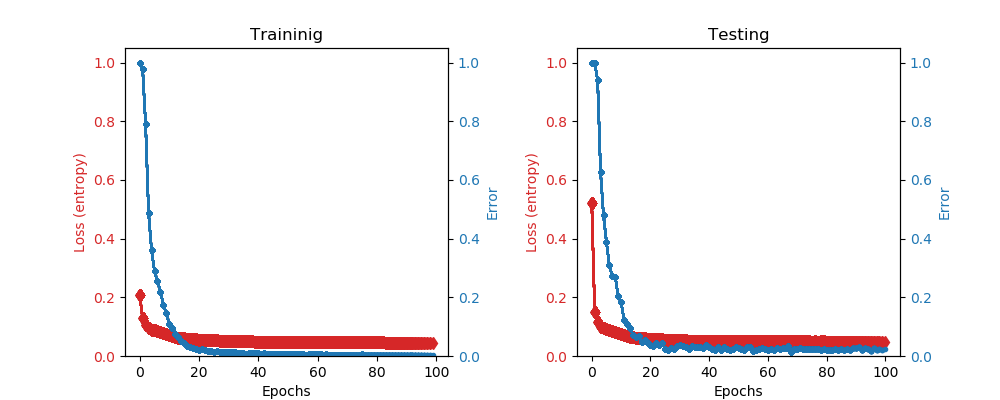

In [8]:
sudoku_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: sudoku_model = sudoku_model.cuda()
    
optimizer = optim.Adam(sudoku_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

In [9]:
test(args.boardSz, 0, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, sudoku_model, optimizer, train_logger, sudoku_train, args.batchSz)
    test(args.boardSz, epoch, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)

  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.5209 Err: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1513 Err: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1158 Err: 0.9400


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1005 Err: 0.6270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0938 Err: 0.4790


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0908 Err: 0.3890


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0880 Err: 0.3090


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0860 Err: 0.2720


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0831 Err: 0.2710


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0792 Err: 0.2030


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0759 Err: 0.1840


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0718 Err: 0.1240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0689 Err: 0.1100


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0663 Err: 0.0960


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0640 Err: 0.0730


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0628 Err: 0.0640


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0612 Err: 0.0670


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0601 Err: 0.0480


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0597 Err: 0.0530


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0586 Err: 0.0440


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0583 Err: 0.0390


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0574 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0570 Err: 0.0440


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0567 Err: 0.0390


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0566 Err: 0.0450


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0561 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0550 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0554 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0542 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0544 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0543 Err: 0.0390


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0539 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0534 Err: 0.0310


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0526 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0528 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0525 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0524 Err: 0.0320


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0522 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0520 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0521 Err: 0.0380


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0519 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0515 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0511 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0516 Err: 0.0310


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0515 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0513 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0509 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0510 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0513 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0512 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0513 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0509 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0506 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0512 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0508 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0507 Err: 0.0180


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0508 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0504 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0506 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0503 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0502 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0505 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0503 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0505 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0502 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0504 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0501 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0501 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0500 Err: 0.0150


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0497 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0499 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0498 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0497 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0497 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0495 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0495 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0190


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0493 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0493 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0488 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0488 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0180


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0488 Err: 0.0200


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0488 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0486 Err: 0.0220


Epoch 100 Test  Loss 0.0477 Err: 0.0000: 100%|██████████| 25/25 [00:05<00:00,  5.03it/s]


TESTING SET RESULTS: Average loss: 0.0486 Err: 0.0230


# The Permutated Sudoku Experiment

<IPython.core.display.Javascript object>


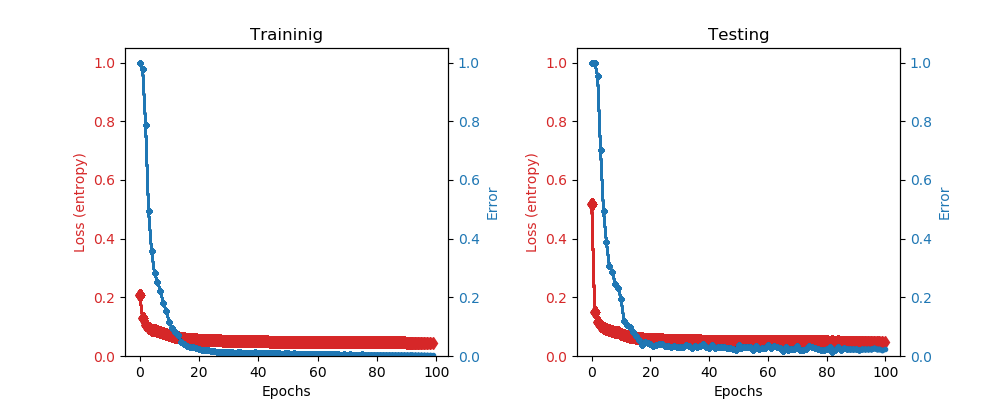

In [10]:
perm_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: perm_model = perm_model.cuda()
    
optimizer = optim.Adam(perm_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

In [11]:
unperm = find_unperm(perm)
test(args.boardSz, 0, perm_model, optimizer, test_logger, perm_test, args.batchSz, unperm)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, perm_model, optimizer, train_logger, perm_train, args.batchSz, unperm)
    test(args.boardSz, epoch, perm_model, optimizer, test_logger, perm_test, args.batchSz, unperm)

  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.5192 Err: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1497 Err: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1166 Err: 0.9540


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1020 Err: 0.7010


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0941 Err: 0.4950


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0913 Err: 0.3870


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0884 Err: 0.3070


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0868 Err: 0.2870


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0828 Err: 0.2450


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0802 Err: 0.2330


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0758 Err: 0.1930


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0726 Err: 0.1190


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0687 Err: 0.1040


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0660 Err: 0.0980


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0640 Err: 0.0810


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0630 Err: 0.0680


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0613 Err: 0.0550


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0600 Err: 0.0380


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0593 Err: 0.0490


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0589 Err: 0.0460


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0583 Err: 0.0410


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0575 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0570 Err: 0.0370


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0567 Err: 0.0420


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0563 Err: 0.0400


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0556 Err: 0.0330


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0552 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0551 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0550 Err: 0.0330


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0544 Err: 0.0310


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0544 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0540 Err: 0.0320


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0537 Err: 0.0370


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0538 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0533 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0532 Err: 0.0330


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0533 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0529 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0527 Err: 0.0420


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0525 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0525 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0526 Err: 0.0370


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0519 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0522 Err: 0.0310


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0517 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0521 Err: 0.0320


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0520 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0517 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0512 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0510 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0514 Err: 0.0380


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0513 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0511 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0512 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0512 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0509 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0510 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0506 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0508 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0506 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0507 Err: 0.0370


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0504 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0504 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0507 Err: 0.0300


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0504 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0500 Err: 0.0180


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0502 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0502 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0501 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0499 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0502 Err: 0.0340


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0498 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0500 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0497 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0499 Err: 0.0350


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0498 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0280


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0495 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0498 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0290


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0495 Err: 0.0150


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0210


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0496 Err: 0.0310


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0494 Err: 0.0260


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0493 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0220


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0230


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0492 Err: 0.0270


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0490 Err: 0.0250


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0240


  0%|          | 0/225 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0489 Err: 0.0220


Epoch 100 Test  Loss 0.0481 Err: 0.0000: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


TESTING SET RESULTS: Average loss: 0.0491 Err: 0.0230


# The End-to-End MNIST Sudoku Experiment

<IPython.core.display.Javascript object>


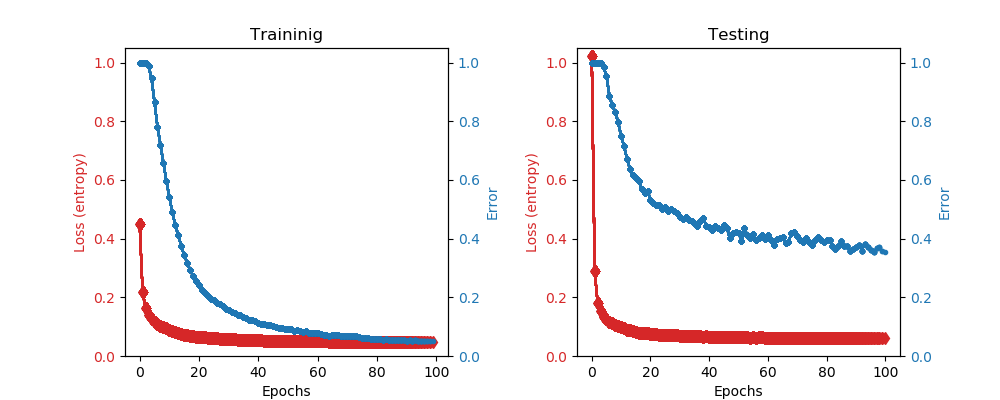

In [12]:
mnist_sudoku = MNISTSudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: mnist_sudoku = mnist_sudoku.cuda()
    
optimizer = optim.Adam([
            {'params': mnist_sudoku.sudoku_solver.parameters(), 'lr': args.lr},
            {'params': mnist_sudoku.digit_convnet.parameters(), 'lr': 1e-5},
            ])

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

In [13]:
test(args.boardSz, 0, mnist_sudoku, optimizer, test_logger, mnist_test, args.mnistBatchSz)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, mnist_sudoku, optimizer, train_logger, mnist_train, args.mnistBatchSz)
    test(args.boardSz, epoch, mnist_sudoku, optimizer, test_logger, mnist_test, args.mnistBatchSz)

  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 1.0215 Err: 1.0000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.2891 Err: 1.0000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1812 Err: 1.0000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1524 Err: 1.0000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1327 Err: 0.9850


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1247 Err: 0.9560


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1156 Err: 0.8880


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1113 Err: 0.8540


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1064 Err: 0.8320


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1021 Err: 0.7970


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0983 Err: 0.7490


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0942 Err: 0.7150


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0901 Err: 0.6730


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0877 Err: 0.6370


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0839 Err: 0.6180


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0816 Err: 0.6080


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0800 Err: 0.5970


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0794 Err: 0.5690


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0777 Err: 0.5570


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0770 Err: 0.5630


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0758 Err: 0.5330


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0749 Err: 0.5210


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0740 Err: 0.5150


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0732 Err: 0.5150


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0731 Err: 0.5010


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0723 Err: 0.5070


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0718 Err: 0.4960


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0713 Err: 0.5010


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0707 Err: 0.4930


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0702 Err: 0.4890


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0694 Err: 0.4750


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0693 Err: 0.4680


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0684 Err: 0.4730


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0679 Err: 0.4650


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0683 Err: 0.4600


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0675 Err: 0.4510


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0670 Err: 0.4430


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0667 Err: 0.4600


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0663 Err: 0.4690


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0667 Err: 0.4440


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0661 Err: 0.4390


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0655 Err: 0.4290


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0653 Err: 0.4420


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0652 Err: 0.4350


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0647 Err: 0.4300


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0645 Err: 0.4470


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0640 Err: 0.4380


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0641 Err: 0.4030


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0640 Err: 0.4200


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0637 Err: 0.4240


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0634 Err: 0.4210


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0632 Err: 0.3920


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0641 Err: 0.4360


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0637 Err: 0.4110


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0630 Err: 0.4030


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0633 Err: 0.4150


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0629 Err: 0.3940


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0634 Err: 0.4030


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0632 Err: 0.4110


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0623 Err: 0.4000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0628 Err: 0.4140


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0626 Err: 0.3960


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0621 Err: 0.3790


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0624 Err: 0.4000


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0623 Err: 0.4030


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0626 Err: 0.4070


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0621 Err: 0.3860


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0619 Err: 0.3890


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0627 Err: 0.4180


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0624 Err: 0.4220


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0623 Err: 0.4080


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0617 Err: 0.3950


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0618 Err: 0.3900


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0625 Err: 0.4010


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0616 Err: 0.3890


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0614 Err: 0.3770


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0616 Err: 0.3950


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0621 Err: 0.4050


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0617 Err: 0.3970


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0614 Err: 0.3870


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0614 Err: 0.3950


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0619 Err: 0.3950


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0612 Err: 0.3760


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0611 Err: 0.3650


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0608 Err: 0.3740


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0609 Err: 0.3920


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0609 Err: 0.3750


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0603 Err: 0.3740


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0606 Err: 0.3590


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0608 Err: 0.3640


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0606 Err: 0.3730


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0610 Err: 0.3800


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0601 Err: 0.3590


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0604 Err: 0.3830


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0603 Err: 0.3700


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0603 Err: 0.3610


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0602 Err: 0.3540


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0606 Err: 0.3680


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0601 Err: 0.3730


  0%|          | 0/180 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.0602 Err: 0.3580


Epoch 100 Test  Loss 0.0592 Err: 0.3000: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


TESTING SET RESULTS: Average loss: 0.0599 Err: 0.3550
